In [1]:
import sys
import math
import numpy as np
from netCDF4 import Dataset as NC
import matplotlib.pyplot as plt
import tqdm
from scipy import ndimage
import subprocess
import copy

In [2]:
def get_nc_data(file, var, time):
    ds = NC(file)
    avail_vars = [nc_var for nc_var in ds.variables]
    if var not in avail_vars:
        raise ValueError('variable not found; must be in {}'.format(avail_vars))
    else:
        var_data = ds[var][time][:]
    return var_data

In [3]:
filename = "icecap_conf.nc"
nc = NC(filename, 'w', format="NETCDF3_CLASSIC")
var = nc.createVariable("pism_overrides", 'i')

ice_temp = 268
A = 1.733e3*np.exp(-13.9e4/(8.3*ice_temp))

attrs = {#"ocean.always_grounded": "no",
         "geometry.update.use_basal_melt_rate": "no",
         "stress_balance.ssa.compute_surface_gradient_inward": "no",
         "flow_law.isothermal_Glen.ice_softness": A,
         "constants.ice.density": 900.,
         "constants.sea_water.density": 1000.,
         "bootstrapping.defaults.geothermal_flux": 0.0,
         "stress_balance.ssa.Glen_exponent": 3.,
         "constants.standard_gravity": 9.81,
         "ocean.sub_shelf_heat_flux_into_ice": 0.0,
         "stress_balance.sia.bed_smoother.range": 0.0,
         }

for name, value in attrs.items():
    var.setncattr(name, value)

nc.close()

In [4]:
WRIT_FILE = 'icecap_initialSetup.nc'

### CONSTANTS ###

secpera = 31556926.
ice_density = 900.0             # [kg m-3]

Lx = 2 * 25e3  # in km
Ly = 2 * 25e3  # in km

dx, dy = 1e3,1e3

# grid size: # of boxes

ny = int(np.floor(Lx / dx) + 1)  # make it an odd number
nx = int(np.floor(Ly / dy) + 1)  # make it an odd number

# grid size: extent in km's, origin (0,0) in the center of the domain

x = np.linspace(-Lx, Lx, nx)
y = np.linspace(-Ly, Ly, ny)

nxcenter = int(np.floor(0.5 * nx))
nycenter = int(np.floor(0.5 * ny))

surf = np.ones((ny, nx))
topg = np.zeros((ny, nx))
tauc = np.zeros((ny, nx))
ice_surface_temp = np.ones((ny, nx))*268.15
precip = np.zeros((ny, nx))
land_ice_area_fraction_retreat = np.ones_like(topg)

base = np.ones((ny, nx)) * (x/100+500)

for i in range(0, nx):
    for j in range(0, ny):
        dist = ((x[i])**2+(y[j])**2)**0.5
        dist2a=((x[i]-Lx/5)**2+(y[j]-Ly/5)**2)**0.5
        dist2b=((x[i]+Lx/5)**2+(y[j]+Ly/5)**2)**0.5
        dist2c = ((2*(x[i])+Lx/5)**2+(2*(y[j])-Ly/5)**2)**0.5
        dist2d = ((2*(x[i])-Lx/5)**2+(2*(y[j])+Ly/5)**2)**0.5
        # add 10k to topography to prevent floating ice
        topg[i, j] = (np.maximum(500*(1-dist2a*5/Lx),0)+np.maximum(500*(1-dist2b*5/Lx),0)+np.maximum(500*(1-dist2c*5/Lx),0)+np.maximum(500*(1-dist2d*5/Lx),0))
        #topg[i,j ] = np.maximum(500 *(1-(dist*2/Lx)), 0)
        precip[i, j] = 5 *(1-(dist*2/Lx))
        surf[i,j] = topg[i,j]+1

#bump = np.zeros((ny, nx))
tauc = np.ones((ny,nx))*5e7
for i in range(0,nx):
    for j in range(0, ny):
        #bump[i,j] = 300*np.exp((-(y[j]+10000)**2)/(2*5000**2))
        if j<=24:
            tauc[i,j] -= 4e7*np.exp((-(x[i])**2)/(2*10000**2))
        dist = ((x[i])**2+(y[j]-15000)**2)**0.5
        #precip[i, j] = 4 *(1-(dist*2/Lx))

        
#topg = base + bump
tauc = np.ones((ny, nx))*1e10
thk = np.ones((ny,nx))
surf = topg+thk

Text(0.5, 1.0, 'true tauc')

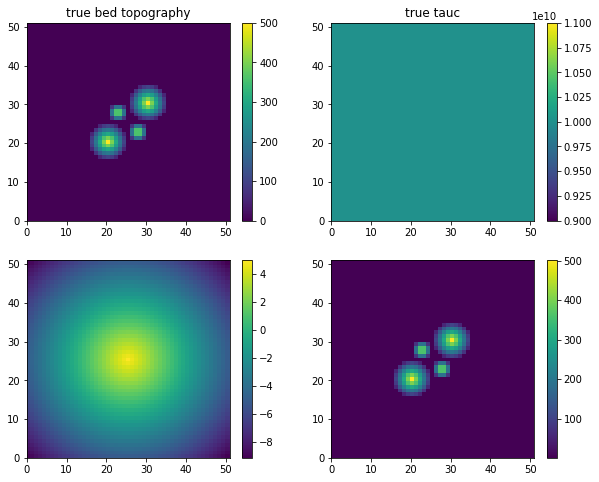

In [5]:
fig, ax = plt.subplots(2,2, figsize=(10,8))
field = ax[0,0].pcolor(topg)
field1 = ax[0,1].pcolor(tauc)
field2 = ax[1,0].pcolor(precip)
field3 = ax[1,1].pcolor(surf)

fig.colorbar(field, ax = ax[0,0])
fig.colorbar(field1, ax = ax[0,1])
fig.colorbar(field2, ax = ax[1,0])
fig.colorbar(field3, ax = ax[1,1])

ax[0,0].set_title('true bed topography')
ax[0,1].set_title('true tauc')

In [6]:
##### define variables, set attributes, write data #####
# format: ['units', 'long_name', 'standard_name', '_FillValue', array]

vars = {'y':    ['m',
                 'y-coordinate in Cartesian system',
                 'projection_y_coordinate',
                 None,
                 y],
        'x':    ['m',
                 'x-coordinate in Cartesian system',
                 'projection_x_coordinate',
                 None,
                 x],
        'thk':  ['m',
                 'floating ice shelf thickness',
                 'land_ice_thickness',
                 None,
                 thk],
        'topg': ['m',
                 'bedrock surface elevation',
                 'bedrock_altitude',
                 None,
                 topg],
        'ice_surface_temp': ['K',
                             'annual mean air temperature at ice surface',
                             'surface_temperature',
                             None,
                             ice_surface_temp],
        'climatic_mass_balance': ['kg m-2 year-1',
                                  'mean annual net ice equivalent accumulation rate',
                                  'land_ice_surface_specific_mass_balance_flux',
                                  None,
                                  precip * ice_density],
        'land_ice_area_fraction_retreat' : ["1",
                                            "maximum ice extent mask",
                                            "",
                                            None,
                                            land_ice_area_fraction_retreat],
        'tauc': ['Pa',
                 'yield stress for basal till (plastic or pseudo-plastic model)',
                 'yield stress',
                 None,
                 tauc],
        }

##### define dimensions in NetCDF file #####
def create_nc_input(vars, WRIT_FILE):
    ncfile = NC(WRIT_FILE, 'w', format='NETCDF3_CLASSIC')
    xdim = ncfile.createDimension('x', nx)
    ydim = ncfile.createDimension('y', ny)
    
    for name in list(vars.keys()):
        [_, _, _, fill_value, data] = vars[name]
        if name in ['x', 'y']:
            var = ncfile.createVariable(name, 'f4', (name,))
        else:
            var = ncfile.createVariable(name, 'f4', ('y', 'x'), fill_value=fill_value)
        for each in zip(['units', 'long_name', 'standard_name'], vars[name]):
            if each[1]:
                setattr(var, each[0], each[1])
        var[:] = data
    
    # finish up
    ncfile.close()
    print("NetCDF file ", WRIT_FILE, " created")
    print('')
    
create_nc_input(vars, WRIT_FILE)

NetCDF file  icecap_initialSetup.nc  created



In [12]:
def create_script(forward_or_iteration):
    print("""#!/bin/bash
    ###### run script for experiment icecap ######""")
    print('# build the PISM command')
    print('set -e #exit on error')
    print('')
    print('NN="$1"')
    print('CLIMATEFILE="$2"')
    print('DURATION=$3')
    print('OUTNAME=$4')
    print('OPT5=$5')
    print('RUNTIME="-ys 0 -ye $DURATION"')
    
    print('')
    print('CLIMATE="-surface given -surface_given_file $CLIMATEFILE"')
    print('grid="-Mx 51 -My 51 -Mz 30 -Mbz 1 -Lz 5000 -Lbz 1 -grid.recompute_longitude_and_latitude false"')
    print('PHYS="-stress_balance ssa+sia -ssa_flow_law isothermal_glen -sia_flow_law isothermal_glen"')
    print('THERMAL="-energy none"')
    print('CONF="-config_override icecap_conf.nc"')

    
    print('SLIDING="-pseudo_plastic -pseudo_plastic_q 0.33333 -pseudo_plastic_uthreshold 3.1556926e7 -yield_stress constant"')
    
    print('echo')
    print('echo "# ======================================================================="')
    print('echo "# create icecap"')
    print('echo "#  $NN processors, $DURATION a run, 50 km grid, $CLIMATEFILE, $4"')
    print('echo "# ======================================================================="')
    
    print('')
    print('PISM_MPIDO="mpiexec -n "')
    
    print('')
    print('PISM_BIN=/home/thomas/pism_dev/bin')
    print('PISM_EXEC="pismr"')
    print('EXVARS="temppabase,tempicethk_basal,velsurf_mag,mask,thk,usurf,velbase_mag, uvel, vvel"')
    
    print('')
    print('PISM="${PISM_BIN}/${PISM_EXEC}"')
    
    print('')
    print('EXSTEP=100')
    print('TSNAME=ts_$OUTNAME')
    print('TSTIMES=0:yearly:$DURATION')
    print('EXNAME=ex_$OUTNAME')
    print('EXTIMES=0:$EXSTEP:$DURATION')
    print('DIAGNOSTICS="-ts_file $TSNAME -ts_times $TSTIMES -extra_file $EXNAME -extra_times $EXTIMES -extra_vars $EXVARS"')
    
    print('DIAGNOSTICS_ITER="-save_file s_$OUTNAME -save_times $OPT5 -save_force_output_times"')

    
    print('')
    if forward_or_iteration == 'forward':
        print('cmd="$PISM_MPIDO $NN $PISM -i $CLIMATEFILE -bootstrap ${grid} $SLIDING $THERMAL $CONF $RUNTIME $CLIMATE $PHYS $DIAGNOSTICS -o $OUTNAME"')
    elif forward_or_iteration == 'iteration':
        print('cmd="$PISM_MPIDO $NN $PISM -i $CLIMATEFILE $CONF $DIF $ENHANCE $SLIDING $THERMAL $OCEAN $RUNTIME $CLIMATE $PHYS $DIAGNOSTICS_ITER -o $OUTNAME"')
    
    print('')
    print('echo')
    print('$cmd')

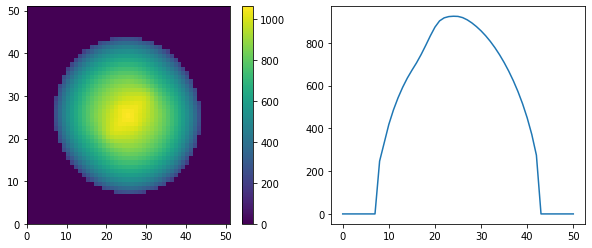

In [8]:
nc_data = get_nc_data('ice_build_output.nc', 'usurf', 0)
fig, axes = plt.subplots(1,2, figsize=(10,4))
colors = axes[0].pcolor(nc_data)
fig.colorbar(colors, ax=axes[0])
axes[1].plot(range(ny), nc_data[:,19])

In [13]:
# bed recovery ###
S_ref = get_nc_data('ice_build_output.nc', 'usurf', 0)
S_rec = copy.deepcopy(S_ref)

h_ref = get_nc_data('ice_build_output.nc', 'thk', 0)
B_rec = np.zeros_like(topg)
dh_ref = np.zeros_like(topg)
B_init = copy.deepcopy(B_rec)

tauc_rec = np.ones_like(tauc)*10e7
tauc_init = copy.deepcopy(tauc_rec)
vel_ref = get_nc_data('ice_build_output.nc', 'velsurf_mag', 0).data

mask = get_nc_data('ice_build_output.nc', 'mask', 0)/2

B_rec_all = []
dh_all = []
B_misfit_vs_iter = []
dh_misfit_vs_iter = []
tauc_rec_all = []
vel_all = []
tauc_misfit_vs_iter=[]
vel_misfit_vs_iter=[]
misfit_thk_all = []
misfit_fr_all = []
S_rec_all = []

pmax =100
dt = .1
beta = 1
bw = 3

!cp ice_build_output.nc icecap_iteration_out.nc
    
original_stdout = sys.stdout
with open('icecap_iteration_script.sh', 'w') as f:
    sys.stdout = f
    create_script('iteration')
    sys.stdout = original_stdout
    f.close()

!cp icecap_iteration_out.nc icecap_iteration_in.nc
!chmod +x icecap_iteration_script.sh

In [14]:
for p in tqdm.trange(0, pmax):  
    
    h_old = S_rec - B_rec
    
    !cp icecap_iteration_out.nc icecap_iteration_in.nc

    nc_updated = NC('icecap_iteration_in.nc', 'r+')
    nc_updated['tauc'][0,:,:]=tauc_rec
    nc_updated['thk'][0,:,:]=h_old
    nc_updated['topg'][0,:,:]=B_rec
    nc_updated.close()
        

    cmd = ["./icecap_iteration_script.sh", '4', 'icecap_iteration_in.nc', str(dt), 'icecap_iteration_out.nc', str(dt/2)]
    subprocess.call(cmd, stdout=open('icecap_iteration_log.txt', 'a'))
    
    vel_rec = get_nc_data('icecap_iteration_out.nc', 'velsurf_mag', 0).data
    h_rec = get_nc_data('icecap_iteration_out.nc', 'thk', 0)
    dh_rec = (h_rec - h_old)/dt

    u = get_nc_data('icecap_iteration_out.nc', 'uvelsurf', 0).data
    v = get_nc_data('icecap_iteration_out.nc', 'vvelsurf', 0).data
    

    misfit = dh_rec - dh_ref        

    B_rec = B_rec - beta * misfit
    S_rec += beta * 0.01 * misfit

    ### buffer ###
    mask_iter = get_nc_data('icecap_iteration_out.nc', 'mask', 0)/2 
    k = np.ones((bw, bw))
    buffer = ndimage.convolve(mask_iter, k)/(bw)**2 
    criterion = np.logical_and(np.logical_and(buffer > 0, buffer != 1), mask==1)
    B_rec[criterion] = 0
    ### buffer end ###

    B_rec[mask==0] = S_ref[mask==0]
    S_rec[mask==0] = S_ref[mask==0]
    B_rec[B_rec>S_rec] = S_rec[B_rec>S_rec]

    B_rec_all.append(B_rec)
    dh_all.append(dh_rec)
    tauc_rec_all.append(tauc_rec.copy())
    vel_all.append(vel_rec)
    S_rec_all.append(S_rec.copy())
    
    tauc_misfit_vs_iter.append(np.mean(abs(tauc_rec[mask==1]-tauc[mask==1])))
    vel_misfit_vs_iter.append(np.mean(abs(vel_rec[mask==1]-vel_ref[mask==1])))
    B_misfit_vs_iter.append(np.mean(abs(B_rec[mask==1]-topg[mask==1])))
    dh_misfit_vs_iter.append(np.mean(abs(dh_rec[mask==1]-dh_ref[mask==1])))
    misfit[mask==0] = np.nan


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


Text(0.5, 1.0, 'recovered surface elevation')

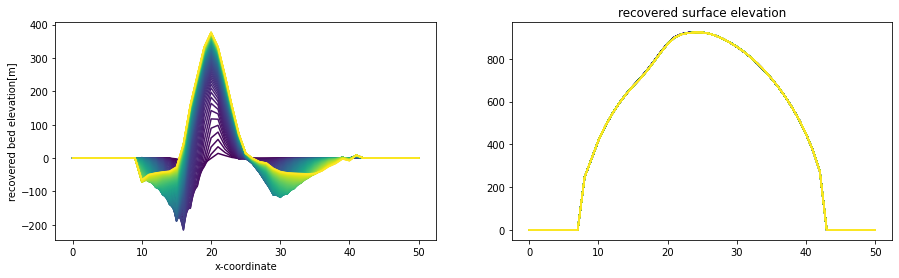

In [15]:
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0,1,len(B_rec_all))]
fig, axes = plt.subplots(1,2, figsize=(15,4))
for i in range(0,len(B_rec_all),1):
    lines = axes[0].plot(range(ny), B_rec_all[i][19,:], color=colors[i])
    lines = axes[1].plot(range(ny), S_rec_all[i][19,:], color=colors[i])

axes[0].set_xlabel('x-coordinate')
axes[0].set_ylabel('recovered bed elevation[m]')
axes[1].set_title('x-coordinate')
axes[1].set_title('recovered surface elevation')